In [1]:
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# TODO
# try turning off the sort with lots of data to see if that improves speed
# tighter prior on sigma or exponential error?

<AxesSubplot:xlabel='stage', ylabel='q'>

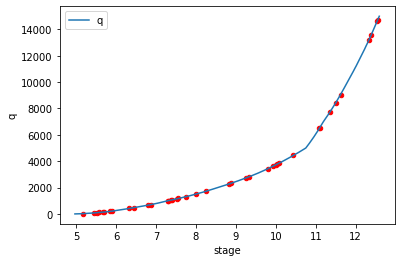

In [4]:
sim_df = pd.read_csv('../data/simulated_rating.csv')
df = sim_df.sample(40)
df = df.sort_values(by='q') #XXX sort or plotting goes crazy
fig, ax = plt.subplots()
sim_df.plot(x='stage',y='q', ax=ax)#, marker='.')
df.plot.scatter(x='stage',y='q', marker='o', color='red', ax=ax)

In [24]:
## Uniform prior
import pymc as pm
from pymc import Model
import pymc.distributions.transforms as tr

from transforms import LogZTransform

import aesara
import aesara.tensor as at

h_obs = df['stage'].values.reshape(-1,1)
    
q_obs = df['q'].values.reshape(-1,1)
q_transform = LogZTransform(q_obs)
y = q_transform.transform(q_obs)


segments = 2

h_max = h_obs.max()
h_min = h_obs.min()


inf = at.constant([np.inf])

clips_array = np.zeros(segments)
clips_array[0] = -np.inf
# TODO may be unnecessary?
clips = at.constant(clips_array)

COORDS = {"obs" : np.arange(len(y)), "splines":np.arange(segments)}
#self.add_coords(COORDS)

with Model(coords=COORDS) as model:
    
    h0_offset = np.ones(segments)
    h0_offset[0] = 0 #
    
    #PRIORS
    w = pm.Normal("w", mu=2.08, sigma=0.3, dims="splines")
    #w = pm.Laplace("w", 2.08, 0.3, dims="splines")
    a = pm.Normal("a", mu=0, sigma=10)
    
    
    # for some reason tr.ordered doesnt work
    # TODO raise bug
    #hs = pm.Uniform('hs',
    hs_ = pm.Uniform('hs_', 
                    lower=0, #XXX
                    upper=h_max,
                    #transform=tr.ordered,
                    shape = segments,
                    initval=[0.3, 10.0])
                    #initval=[0.3, 5.7, 10.0]) # define a function to compute
    
    hs = pm.Deterministic('hs', at.sort(hs_))

    hsi = at.concatenate([hs, inf])[1:] #can we avoid?

    # enforce that 
    pm.Potential('minimum', at.switch(hs[1]>h_min, 0, -np.inf))
    pm.Potential('maximum', at.switch(hs[-1]<h_max, 0, -np.inf)) #REMOVE
    

    # MODEL
    h0 = hs - h0_offset #XXX check this. should it be a tensor?


    b0 = at.switch( at.le(h_obs, hs), clips , at.log(h_obs-h0))
    b1 = at.switch( at.le(h_obs, hsi), b0, at.log(hsi-h0))

    
    mu = pm.Deterministic("mu", a + at.dot(b1, w)) # was w.T
    sigma = pm.HalfCauchy("sigma", beta=1, initval=0.01)
    #sigma = pm.Exponential("sigma", lam=1, initval=0.1)
    #D = pm.Normal("D", mu, sigma, observed=y, dims="obs")
    D = pm.Normal("D", mu, sigma, observed=y.flatten(), dims="obs") #TODO check flatten

In [25]:
# CompileD XXXX
n=4

with model:
    trace = pm.sample(tune=2000, chains=n, cores=n, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a, hs_, sigma]


KeyError: 0

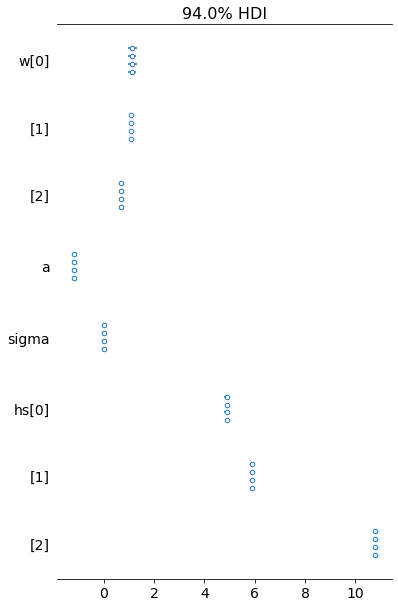

In [26]:
az.plot_forest(trace, var_names=["w","a","sigma","hs"], combined=False);

In [8]:
#with model:
#    mean_field = pm.fit(method="advi", n=100_000)

In [ ]:
#vi_trace = mean_field.sample(5000) #was 5
#az.summary(vi_trace, var_names=["w","a","sigma","hs"])

In [19]:
## Normal version

import pymc as pm
from pymc import Model
import pymc.distributions.transforms as tr

from transforms import LogZTransform

import aesara
import aesara.tensor as at

h_obs = df['stage'].values.reshape(-1,1)
    
q_obs = df['q'].values.reshape(-1,1)
q_transform = LogZTransform(q_obs)
y = q_transform.transform(q_obs)

breaks = np.array([4., 5., 10.0])
breaks_sigma = np.array([3.0, 0.6, 1.0])
segments = 3

h_max = h_obs.max()
h_min = h_obs.min()


inf = at.constant([np.inf])


clips_array = np.zeros(segments)
clips_array[0] = -np.inf
# TODO may be unnecessary?
clips = at.constant(clips_array) # TODO could be a problem with clips?

COORDS = {"obs" : np.arange(len(y)), "splines":np.arange(segments)}
#self.add_coords(COORDS)

with Model(coords=COORDS) as model:
    
    h0_offset = np.ones(segments)
    h0_offset[0] = 0 #
    
    #PRIORS
    w = pm.Normal("w", mu=2.08, sigma=0.3, dims="splines")
    #w = pm.Normal("w", mu=2.08, sigma=1, dims="splines")
    a = pm.Normal("a", mu=0, sigma=10)
    
    
    # for some reason tr.ordered doesnt work
    # TODO raise bug
    #hs = pm.Uniform('hs',
    hs_ = pm.Normal('hs_', 
                    breaks,
                    breaks_sigma,
                    #upper=h_max,
                    #transform=tr.ordered,
                    shape = segments,
                    initval=[0.3, 5.0, 10.0]) # define a function to compute
    
    hs = pm.Deterministic('hs', at.sort(hs_))

    hsi = at.concatenate([hs, inf])[1:] #can we avoid?

    # enforce that 
    pm.Potential('minimum', at.switch(hs[1]>h_min, 0, -np.inf))
    pm.Potential('maximum', at.switch(hs[-1]<h_max, 0, -np.inf))
    

    # MODEL
    h0 = hs - h0_offset #XXX check this. should it be a tensor?


    b0 = at.switch( at.le(h_obs, hs), clips , at.log(h_obs-h0))
    b1 = at.switch( at.le(h_obs, hsi), b0, at.log(hsi-h0))

    
    mu = pm.Deterministic("mu", a + at.dot(b1, w)) # was w.T
    sigma = pm.HalfCauchy("sigma", beta=1, initval=0.01)
    #D = pm.Normal("D", mu, sigma, observed=y, dims="obs")
    D = pm.Normal("D", mu, sigma, observed=y.flatten(), dims="obs") #TODO check flatten

In [20]:
# CompileD XXXX
n=4

with model:
    trace = pm.sample(tune=2000, chains=n, cores=n, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a, hs_, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 131 seconds.


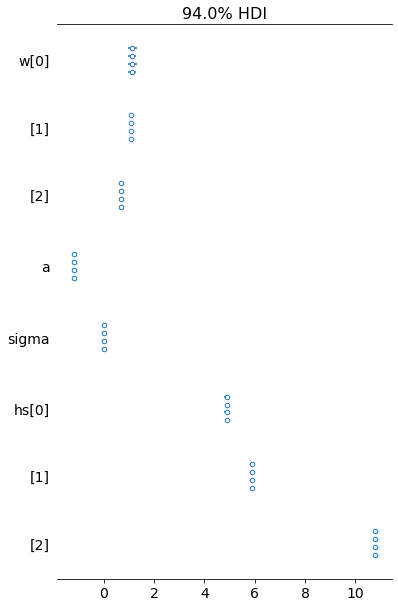

In [21]:
az.plot_forest(trace, var_names=["w","a","sigma","hs"], combined=False);

In [33]:
az.summary(trace, var_names=["w","a","sigma","hs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.746,0.148,1.476,2.016,0.005,0.004,947.0,1197.0,1.0
w[1],1.369,0.015,1.341,1.396,0.000,0.000,1442.0,1771.0,1.0
w[2],0.818,0.007,0.804,0.830,0.000,0.000,2821.0,2359.0,1.0
a,-1.908,0.089,-2.066,-1.755,0.003,0.002,1033.0,1226.0,1.0
sigma,0.018,0.001,0.015,0.020,0.000,0.000,3064.0,2634.0,1.0
hs[0],4.755,0.052,4.661,4.851,0.002,0.001,973.0,1156.0,1.0
hs[1],5.788,0.025,5.741,5.834,0.001,0.000,1328.0,2058.0,1.0
hs[2],10.733,0.017,10.700,10.765,0.000,0.000,2966.0,2357.0,1.0


In [14]:
h_max

12.31

In [23]:
with model:
    mean_field = pm.fit(method="advi", n=100_000)

/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `a`.ravel()[0] is NaN.
The current approximation of RV `w`.ravel()[0] is NaN.
The current approximation of RV `w`.ravel()[1] is NaN.
The current approximation of RV `w`.ravel()[2] is NaN.
The current approximation of RV `sigma_log__`.ravel()[0] is NaN.
The current approximation of RV `hs_`.ravel()[0] is NaN.
The current approximation of RV `hs_`.ravel()[1] is NaN.
The current approximation of RV `hs_`.ravel()[2] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [16]:
vi_trace = mean_field.sample(5000) #was 5
az.summary(vi_trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.980,0.060,1.864,2.089,0.001,0.001,4881.0,4705.0,NaN
w[1],1.484,0.030,1.425,1.537,0.000,0.000,4211.0,4670.0,NaN
a,-3.570,0.045,-3.654,-3.483,0.001,0.000,4225.0,4676.0,NaN
sigma,0.261,0.033,0.202,0.323,0.000,0.000,5056.0,4983.0,NaN
hs[0],2.910,0.051,2.814,3.003,0.001,0.001,4883.0,4974.0,NaN
hs[1],5.048,0.067,4.929,5.176,0.001,0.001,4863.0,4815.0,NaN


In [17]:
az.summary(vi_trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.980,0.060,1.864,2.089,0.001,0.001,4881.0,4705.0,NaN
w[1],1.484,0.030,1.425,1.537,0.000,0.000,4211.0,4670.0,NaN
a,-3.570,0.045,-3.654,-3.483,0.001,0.000,4225.0,4676.0,NaN
sigma,0.261,0.033,0.202,0.323,0.000,0.000,5056.0,4983.0,NaN
hs[0],2.910,0.051,2.814,3.003,0.001,0.001,4883.0,4974.0,NaN
hs[1],5.048,0.067,4.929,5.176,0.001,0.001,4863.0,4815.0,NaN


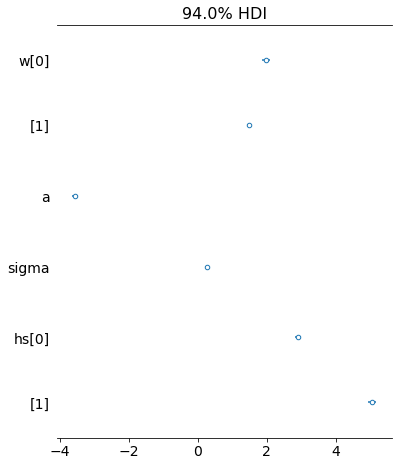

In [18]:
az.plot_forest(vi_trace, var_names=["w","a","sigma","hs"], combined=False);

# vectorized version

In [ ]:
mu = at.add(*[rho[i] * stacked_value[ar_order - (i+1): -(i+1)] for i in range(ar_order)])

In [ ]:
## Uniform prior
import pymc as pm
from pymc import Model
import pymc.distributions.transforms as tr

from transforms import LogZTransform

import aesara
import aesara.tensor as at

h_obs = df['stage'].values.reshape(-1,1)
    
q_obs = df['q'].values.reshape(-1,1)
q_transform = LogZTransform(q_obs)
y = q_transform.transform(q_obs)


segments = 2

h_max = h_obs.max()
h_min = h_obs.min()


inf = at.constant([np.inf])

clips_array = np.zeros(segments)
clips_array[0] = -np.inf
# TODO may be unnecessary?
clips = at.constant(clips_array)

COORDS = {"obs" : np.arange(len(y)), "splines":np.arange(segments)}
#self.add_coords(COORDS)

with Model(coords=COORDS) as model:
    
    h0_offset = np.ones(segments)
    h0_offset[0] = 0 #
    
    #PRIORS
    w = pm.Normal("w", mu=2.08, sigma=0.3, dims="splines")
    #w = pm.Laplace("w", 2.08, 0.3, dims="splines")
    a = pm.Normal("a", mu=0, sigma=10)
    
    
    # for some reason tr.ordered doesnt work
    # TODO raise bug
    #hs = pm.Uniform('hs',
    hs_ = pm.Uniform('hs_', 
                    lower=0, #XXX
                    upper=h_max,
                    #transform=tr.ordered,
                    shape = segments,
                    initval=[0.3, 10.0])
                    #initval=[0.3, 5.7, 10.0]) # define a function to compute
    
    hs = pm.Deterministic('hs', at.sort(hs_))

    hsi = at.concatenate([hs, inf])[1:] #can we avoid?

    # enforce that 
    pm.Potential('minimum', at.switch(hs[1]>h_min, 0, -np.inf))
    pm.Potential('maximum', at.switch(hs[-1]<h_max, 0, -np.inf)) #REMOVE
    

    # MODEL
    h0 = hs - h0_offset #XXX check this. should it be a tensor?


    b0 = at.switch( at.le(h_obs, hs), clips , at.log(h_obs-h0))
    b1 = at.switch( at.le(h_obs, hsi), b0, at.log(hsi-h0))

    
    mu = pm.Deterministic("mu", a + at.dot(b1, w)) # was w.T
    sigma = pm.HalfCauchy("sigma", beta=1, initval=0.01)
    #sigma = pm.Exponential("sigma", lam=1, initval=0.1)
    #D = pm.Normal("D", mu, sigma, observed=y, dims="obs")
    D = pm.Normal("D", mu, sigma, observed=y.flatten(), dims="obs") #TODO check flatten

In [38]:
##fails
#with model:
#    mean_field = pm.fit(method="advi", n=30_000)

#vi_trace = mean_field.sample()
#az.plot_forest(vi_trace, var_names=["w","a","sigma","hs_"], combined=False);

In [39]:
#https://discourse.pymc.io/t/sampling-from-simplex-with-inequality-constraints/3285
# THis example illustrates that we can convert an RV to a vector using pm.Determinisitic
# For example, x is not a proper tensor but a is.

import aesara.tensor as tt 

with pm.Model() as model:
    x = [pm.Exponential(f"x{i}", lam=1) for i in range(3)]
    #x = [pm.Exponential(f"x[{i}]", lam=1) for i in range(3)]
    a = pm.Deterministic("a", x / tt.sum(x))
    c0 = pm.Potential('c0', tt.switch(tt.le(a[0], 0.3), 0, -np.inf))  # require that a0 < 0.3
    trace = pm.sample()
    
#az.plot_forest(trace, combined=False);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x0, x1, x2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 771 divergences after tuning. Increase `target_accept` or reparameterize.
There were 738 divergences after tuning. Increase `target_accept` or reparameterize.
There were 874 divergences after tuning. Increase `target_accept` or reparameterize.
There were 751 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8824, but should be close to 0.8. Try to increase the number of tuning steps.


In [38]:
#az.plot_forest(trace, combined=False);

In [13]:
# # Idea from "All that likelihood with PyMC3 - Junpeng Lao"
import pymc as pm
import pymc.distributions.transforms as tr

import aesara
import aesara.tensor as at

with pm.Model() as test:
    mu = pm.Normal('mu',0,2, shape=2, transform=tr.ordered, initval=[0.1,0.2])
    
##
with pm.Model() as test2:
    mu_ = pm.Normal('mu_', 0, 2, shape=2)
    mu2 = at.sort(mu_)

mu2.eval()

array([-1.2867288 ,  3.17255177])

In [38]:
with pm.Model() as test:
    segments = 3
    hs = pm.Normal('hs', 0, 6,
                   transform=tr.ordered,
                   shape=segments)
hs.eval()

array([-6.66499266,  1.60145319, -6.18938302])

In [80]:
# could use this structure to enforce other arbitrary rules 
with pm.Model() as test3:
    mu = pm.Normal('mu', 0., 5., shape=2)
    pm.Potential('order', at.switch(mu[1]<mu[0], -np.inf, 0))

0.7941092550264335

In [ ]:
# another example

with pm.Model() as model:
    x = [pm.Exponential(f"x{i}", lam=1) for i in range(3)]
    a = pm.Deterministic("a", x / tt.sum(x))
    c0 = pm.Potential('c0', tt.switch(tt.le(a[0], 0.3), 0, -np.inf))  # require that a0 < 0.3
    trace = pm.sample()

In [28]:
import pymc as pm
with pm.Model() as model:
    a = pm.Dirichlet('a', [1,1,1])
    #a = pm.Bound(pm.Dirichlet, upper=[0.7])('a', a=np.array([1, 1, 1]))
    
a.eval().sum()

1.0

In [19]:
## other priors
# physixal exponents (w)
import pymc as pm
from pymc import Model
import pymc.distributions.transforms as tr

from transforms import LogZTransform

import aesara
import aesara.tensor as at

h_obs = df['stage'].values.reshape(-1,1)
    
q_obs = df['q'].values.reshape(-1,1)
q_transform = LogZTransform(q_obs)
y = q_transform.transform(q_obs)


segments = 3

h_max = h_obs.max()
h_min = h_obs.min()

#ninf = at.constant([np.NINF])
inf = at.constant([np.inf])
#ninf = at.constant([-99.0])
#inf = at.constant([99.0])

clips_array = np.zeros(segments)
clips_array[0] = -np.inf
# TODO may be unnecessary?
clips = at.constant(clips_array) # TODO could be a problem with clips?

COORDS = {"obs" : np.arange(len(y)), "splines":np.arange(segments)}
#self.add_coords(COORDS)

with Model(coords=COORDS) as model:
    
    h0_offset = np.ones(segments)
    h0_offset[0] = 0 #
    
    #PRIORS
    w = pm.Normal("w", mu=2.08, sigma=0.3, dims="splines")
    a = pm.Normal("a", mu=0, sigma=10)
    
    
    # for some reason tr.ordered doesnt work
    # TODO raise bug
    #hs = pm.Uniform('hs',
    hs_ = pm.Uniform('hs_', 
                    lower=h_min, #XXX
                    upper=h_max,
    #                transform=tr.ordered,
                    shape = segments,
                    initval=[0.3, h_min + 2 ,10.0]) # define a function to compute
    
    hs = at.sort(hs_)

    hsi = at.concatenate([hs, inf])[1:] #can we avoid?
    
    pm.Potential('minimum', at.switch(hs[1]>h_min, 0, -np.inf))
    

    # MODEL
    h0 = hs - h0_offset #XXX check this. should it be a tensor?


    b0 = at.switch( at.le(h_obs, hs), clips , at.log(h_obs-h0))
    b1 = at.switch( at.le(h_obs, hsi), b0, at.log(hsi-h0))

    
    mu = pm.Deterministic("mu", a + at.dot(b1, w.T))
    sigma = pm.HalfCauchy("sigma", beta=1, initval=0.01)
    D = pm.Normal("D", mu, sigma, observed=y.flatten(), dims="obs") #TODO check flatten

In [20]:
hs.eval()

array([ 6.2024958 ,  8.11740644, 10.6789696 ])

In [21]:
# CompileD XXXX
n=1

with model:
    trace = pm.sample(tune=2000, chains=n, cores=n, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'w': array([2.70492759, 2.98608602, 1.17384837]), 'a': array(-0.13268459), 'hs__interval__': array([        nan, -1.73802754,  0.66622457]), 'sigma_log__': array(-4.70603194)}

Initial evaluation results:
{'w': -10.44, 'a': -3.22, 'hs_': nan, 'sigma': -5.16, 'D': nan, 'minimum': 0.0}

In [ ]:
az.plot_forest(trace, var_names=["w","a","sigma","hs_0","hs_1", "hs_2"], combined=False);

In [ ]:
az.summary(trace, var_names=["w","a","sigma","hs"])

# Scratch

In [103]:
    #hs_list = []
    #hs_list.append(pm.Normal('hs_0', 0, 3))
    #hs_list.append(pm.Normal('hs_0', h_min, 3))
    #interval_min = 
    #intervals = pm.Uniform('intervals', 
    #                       lower=h_min, #XXX
    #                       upper=h_max,
    #                       transform=tr.ordered,
    #                       shape = segments - 1
    #                       initval=[5.0,10.0]) # define a function to compute
    
    # impose that sum is less than h_max
    

    # XXX continue here
    #mu = pm.Normal('mu',0,2, shape=2, transform=tr.ordered, initval=[0.1,0.2])
    #for i in range(1,segments):
    #    last = at.max([hs_list[i-1], h_min])
    #    hs_list.append(pm.Uniform('hs_{}'.format(i), last, h_max))
        #hs_list.append(pm.Uniform('hs_{}'.format(i), hs_list[i-1], h_max))
        
    #hs = at.stack(hs_list)   
    #hsi = at.concatenate([hs, inf])[1:]


In [124]:
# CompileD XXXX
n=1

with model:
    trace = pm.sample(tune=2000, chains=n, cores=n, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w, a, hs_0, hs_1, hs_2, sigma]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 220 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


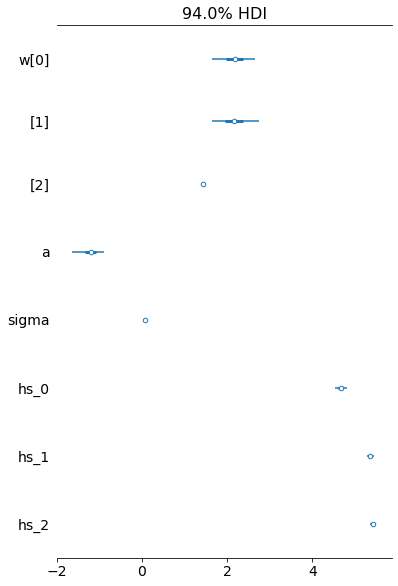

In [125]:
# -99 to 99 thresholds finished in 60 sec with no divergences
az.plot_forest(trace, var_names=["w","a","sigma","hs_0","hs_1", "hs_2"], combined=False);

In [129]:
az.summary(trace, var_names=["w","a","sigma","hs_0","hs_1", "hs_2"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],2.173,0.288,1.633,2.664,0.014,0.010,418.0,579.0,NaN
w[1],2.164,0.305,1.635,2.750,0.011,0.008,760.0,529.0,NaN
w[2],1.429,0.027,1.377,1.480,0.001,0.001,679.0,565.0,NaN
a,-1.212,0.202,-1.643,-0.887,0.012,0.008,322.0,284.0,NaN
sigma,0.080,0.006,0.070,0.091,0.000,0.000,822.0,643.0,NaN
hs_0,4.665,0.079,4.528,4.817,0.004,0.003,314.0,404.0,NaN
hs_1,5.361,0.041,5.287,5.444,0.002,0.001,517.0,268.0,NaN
hs_2,5.419,0.038,5.355,5.499,0.002,0.001,593.0,523.0,NaN


In [127]:
#mean_field.__getstate__()['model']

In [ ]:
with model:
    mean_field = pm.fit(method="advi", n=30_000)

/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,


In [88]:
vi_trace = mean_field.sample(5000)

In [89]:
az.summary(vi_trace, var_names=["w","a","sigma","hs_0","hs_1", "hs_2"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.008,0.002,0.005,0.011,0.000,0.000,5062.0,5111.0,NaN
w[1],2.317,0.164,2.018,2.628,0.002,0.002,4691.0,4749.0,NaN
w[2],1.579,0.009,1.563,1.596,0.000,0.000,4634.0,4633.0,NaN
a,-2.342,0.014,-2.368,-2.316,0.000,0.000,4781.0,4592.0,NaN
sigma,0.108,0.009,0.092,0.125,0.000,0.000,5005.0,4982.0,NaN
hs_0,5.097,0.018,5.064,5.129,0.000,0.000,4721.0,4432.0,NaN
hs_1,5.132,0.026,5.086,5.181,0.000,0.000,5314.0,5014.0,NaN
hs_2,5.217,0.027,5.168,5.268,0.000,0.000,5208.0,4752.0,NaN


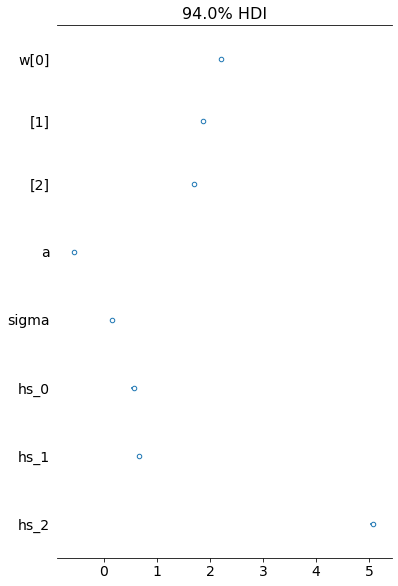

In [78]:
az.plot_forest(vi_trace, var_names=["w","a","sigma","hs_0","hs_1", "hs_2"], combined=False);

In [81]:
### BEST YET!
## other priors
# physixal exponents (w)
import pymc as pm
from pymc import Model
from transforms import LogZTransform

import aesara
import aesara.tensor as at

h_obs = df['stage'].values.reshape(-1,1)
    
q_obs = df['q'].values.reshape(-1,1)
q_transform = LogZTransform(q_obs)
y = q_transform.transform(q_obs)



segments = 3

#ninf = at.constant([np.NINF])
#inf = at.constant([np.inf])
ninf = at.constant([-99.0])
inf = at.constant([99.0]) # needs to be large than largest observed stage

clips_array = np.zeros(segments)
clips_array[0] = ninf.eval()
clips = at.constant(clips_array) # TODO could be a problem with clips?

COORDS = {"obs" : np.arange(len(y)), "splines":np.arange(segments)}
#self.add_coords(COORDS)

with Model(coords=COORDS) as model:

    h0_offset = np.ones(segments)
    h0_offset[0] = 0 #
    
    #PRIORS
    w = pm.Normal("w", mu=2.08, sigma=0.3, dims="splines")
    #w = pm.TruncatedNormal("w", mu=2.08, sigma=0.3, lower=0, dims="splines")
    a = pm.Normal("a", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=1, initval=0.01)
    
    intervals = pm.HalfCauchy("intervals", beta=3.0, shape=segments)
    hs = pm.Deterministic("hs", intervals.cumsum())
    
    hsi = at.concatenate([hs, inf])[1:]
    
    
    # MODEL
    h0 = hs - h0_offset 
    b0 = at.switch( at.le(h_obs, hs), clips , at.log(h_obs-h0))
    b1 = at.switch( at.le(h_obs, hsi), b0, at.log(hsi-h0))
    mu = pm.Deterministic("mu", a + at.dot(b1, w.T))
    
    D = pm.Normal("D", mu, sigma, observed=y.flatten(), dims="obs") #TODO check flatten

In [82]:
hs.eval()

array([ 1.75769953, 16.18204194, 26.04096323])

In [83]:
#df.stage.max()

In [84]:
# CompileD XXXX
# set inf to 10
# inf is hs so could be higher
# ninf is y so -10 may be fine
with model:
    trace = pm.sample(tune=2000, chains=1, target_accept=0.95) #2 minutes before

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w, a, sigma, intervals]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 52 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [85]:
az.summary(trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.333,0.040,1.262,1.405,0.002,0.001,394.0,430.0,NaN
w[1],1.373,0.014,1.346,1.396,0.001,0.001,174.0,312.0,NaN
w[2],0.808,0.009,0.791,0.826,0.000,0.000,781.0,770.0,NaN
a,-1.563,0.008,-1.578,-1.548,0.000,0.000,376.0,617.0,NaN
sigma,0.018,0.001,0.016,0.021,0.000,0.000,883.0,739.0,NaN
hs[0],4.925,0.006,4.913,4.936,0.000,0.000,428.0,439.0,NaN
hs[1],5.825,0.023,5.783,5.868,0.002,0.001,166.0,389.0,NaN
hs[2],10.703,0.017,10.670,10.731,0.001,0.000,858.0,769.0,NaN


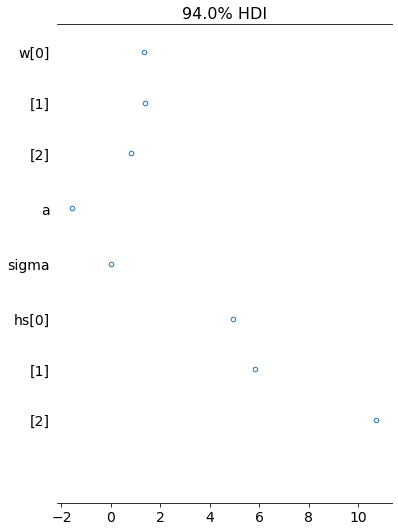

In [86]:
az.plot_forest(trace, var_names=["w","a","sigma", "hs","sigma"], combined=False);

In [97]:
with model:
    mean_field = pm.fit(method="advi", n=100_000)

/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,


Finished [100%]: Average Loss = 25.251


In [98]:
vi_trace = mean_field.sample(5000)

In [99]:
az.summary(vi_trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.929,0.006,1.917,1.941,0.000,0.000,5139.0,5124.0,NaN
w[1],2.076,0.015,2.046,2.104,0.000,0.000,5054.0,4753.0,NaN
w[2],2.095,0.016,2.062,2.124,0.000,0.000,4761.0,4611.0,NaN
a,1.231,0.025,1.185,1.278,0.000,0.000,4829.0,4814.0,NaN
sigma,0.224,0.018,0.193,0.262,0.000,0.000,4705.0,4675.0,NaN
hs[0],1.010,0.032,0.952,1.072,0.000,0.000,4874.0,5024.0,NaN
hs[1],1.029,0.032,0.971,1.090,0.000,0.000,4877.0,5024.0,NaN
hs[2],4.992,0.052,4.894,5.086,0.001,0.001,4951.0,4666.0,NaN


In [ ]:
# Next task, set prior so hs always less than h_max

In [ ]:
def pairplot_divergence(trace, ax=None, divergence=True, color="C3", divergence_color="C2"):
    theta = trace.get_values(varname="theta", combine=True)[:, 0]
    logtau = trace.get_values(varname="tau_log__", combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, "o", color=color, alpha=0.5)
    if divergence:
        divergent = trace["diverging"]
        ax.plot(theta[divergent], logtau[divergent], "o", color=divergence_color)
    ax.set_xlabel("theta[0]")
    ax.set_ylabel("log(tau)")
    ax.set_title("scatter plot between log(tau) and theta[0]")
    return ax


pairplot_divergence(short_trace);

In [11]:
with model:
    mean_field = pm.fit(method="advi", n=30_000)

/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `sigma_log__`.ravel()[0] is NaN.
The current approximation of RV `w`.ravel()[0] is NaN.
The current approximation of RV `w`.ravel()[1] is NaN.
The current approximation of RV `ints_log__`.ravel()[0] is NaN.
The current approximation of RV `a`.ravel()[0] is NaN.
The current approximation of RV `hss`.ravel()[0] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [19]:
vi_trace = mean_field.sample(5000)


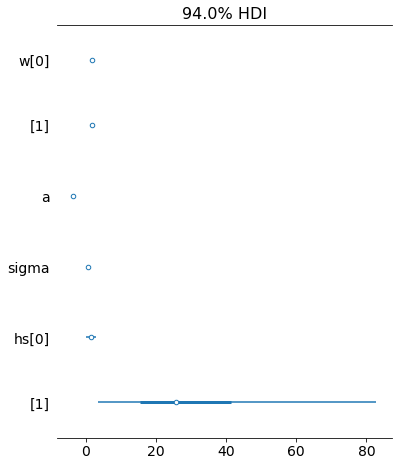

In [22]:
az.plot_forest(vi_trace, var_names=["w","a","sigma", "hs"], combined=False);

In [25]:
az.summary(vi_trace, var_names=["w","a","sigma", "hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.785,0.094,1.602,1.947,0.001,0.001,4788.0,4846.0,NaN
w[1],1.911,0.313,1.346,2.500,0.004,0.003,4917.0,4527.0,NaN
a,-3.509,0.214,-3.893,-3.094,0.003,0.002,4863.0,4452.0,NaN
sigma,0.673,0.131,0.450,0.924,0.002,0.001,4810.0,4561.0,NaN
hs[0],1.541,0.820,0.023,3.076,0.012,0.008,4840.0,4795.0,NaN
hs[1],34.150,31.218,3.624,82.823,0.460,0.325,4891.0,4621.0,NaN


In [26]:
# CompileD XXXX
with model:
    trace = pm.sample(tune=2000, chains=1, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
Sequential sampling (1 chains in 1 job)
NUTS: [w, a, hss, ints, sigma]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 151 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


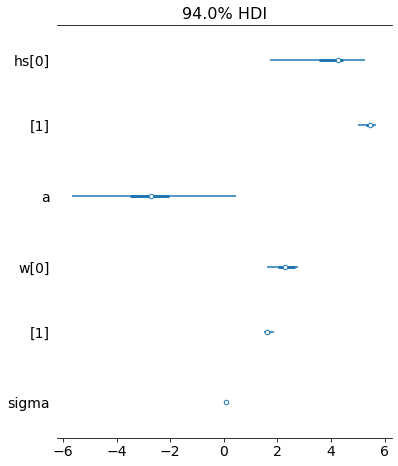

In [24]:
import arviz as az

az.plot_forest(trace, var_names=["hs","a","w","sigma"], combined=False);

In [3]:
#https://github.com/aesara-devs/aesara